# Verification system basing on behavioral biometrics: typing errors

## Configuration
### Load dependencies

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from keras.metrics import AUC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from os.path import isdir, join


from create_model import create_dataset
from logger import logger
from verification_mode import balance_dataset

In [10]:
def run_cv_tf(model, X, y, X_valid, y_valid, n_splits=5, name='',
                           plot_path='results_identification/', title = None, use_weigted_dataset=False):
    kf = KFold(n_splits=n_splits)
    results = []
    # Initialization
    all_far = []
    all_frr = []
    all_tpr = []
    all_eer = []
    cumulative_cm = np.zeros((2, 2)) 
    
    
    for train_index, test_index in kf.split(X):
        # Create train and test datasets using the indices from KFold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logger.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        if use_weigted_dataset:
            unique_classes, class_counts = np.unique(y, return_counts=True)
            class_weight_dict = dict(zip(unique_classes,  len(y_train) / (len(unique_classes) * class_counts)))
            sample_weights = np.array([class_weight_dict[class_val] for class_val in y_train])
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights)).batch(1000)
        else: 
           train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1000) 

        
        X_valid, no_use_x, y_valid, no_use_y = train_test_split(X_valid, y_valid, test_size=0.1)

        model.fit(train_dataset)
        model.compile(metrics=[AUC(name='auc')])
        predictions = model.predict(X_valid, verbose=2)
        predictions = np.hstack((1 - predictions, predictions))

        # predictions = model.predict(X_valid).reshape(-1, 1)
        predictions = model.predict(X_valid)

        predictions = np.hstack((1 - predictions, predictions))  
        y_score = predictions[:, 1]
        # Compute ROC curve metrics
        far, tpr, _ = roc_curve(y_valid, y_score)
        frr = 1 - tpr
        all_frr.append(frr)
        all_far.append(far)
        all_tpr.append(tpr)
        # Compute EER
        eer_index = np.nanargmin(np.absolute(far - frr))
        eer = (far[eer_index] + frr[eer_index]) / 2
        all_eer.append(eer)
        
        cm = confusion_matrix(y_valid, np.argmax(predictions, axis=1))
        cumulative_cm += cm
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (far, tpr) in enumerate(zip(all_far, all_tpr)):
        ax[0].plot(far, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (EER = {all_eer[i]:.2f})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curves')
    ax[0].legend(loc='lower right')
        
    for i, (far, frr) in enumerate(zip(all_far, all_frr)):        
        ax[1].plot(frr, far, color='green', linewidth=2)
        
        ax[1].set_title('T-ROC Curve')
        ax[1].set_xlabel('FRR (False Rejection Rate)')
        ax[1].set_ylabel('FAR (False Acceptance Rate)')
                
    sns.heatmap(cumulative_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Other user', 'User'], yticklabels=['Other user', 'User'], ax=ax[2])        
    ax[2].set_title('Confusion Matrix')
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('Actual')
    plt.tight_layout()
    if isdir(plot_path) and title is not None:
        plt.savefig(join(plot_path, title+'.png'))
    plt.show()    
        

    return pd.DataFrame(results), all_far, all_frr, all_tpr, all_eer, cumulative_cm 


In [5]:
def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

def custom_asymmetric_valid(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [6]:
import lightgbm

def run_cv_lbm_verification(model, X, y, X_valid, y_valid, n_splits=5, name='',
                           plot_path='results_identification/', title = None, is_multiclass=True):
    model = lightgbm.LGBMClassifier() 
    kf = KFold(n_splits=n_splits)
    results = []
    # Initialization
    all_far = []
    all_frr = []
    all_tpr = []
    all_eer = []
    cumulative_cm = np.zeros((2, 2)) 
    for train_index, test_index in kf.split(X):
        # Create train and test datasets using the indices from KFold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logger.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1000)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)
        X_valid, no_use_x, y_valid, no_use_y = train_test_split(X_valid, y_valid, test_size=0.1)
        model.set_params(**{'objective': custom_asymmetric_train}, metrics = ["precision"])

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=custom_asymmetric_valid)

        # predictions = model.predict(X_valid).reshape(-1, 1)
        predictions = model.predict(X_valid)
        print(predictions)
        """

        model.fit(train_dataset)
        model.compile(metrics=[AUC()])
        predictions = model.predict(X_valid, verbose=2)
        """

        predictions = np.hstack((1 - predictions, predictions))  
        y_score = predictions[:, 1]
        # Compute ROC curve metrics
        far, tpr, _ = roc_curve(y_valid, y_score)
        frr = 1 - tpr
        all_frr.append(frr)
        all_far.append(far)
        all_tpr.append(tpr)
        # Compute EER
        eer_index = np.nanargmin(np.absolute(far - frr))
        eer = (far[eer_index] + frr[eer_index]) / 2
        all_eer.append(eer)
        
        cm = confusion_matrix(y_valid, np.argmax(predictions, axis=1))
        cumulative_cm += cm
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))

    for i, (far, tpr) in enumerate(zip(all_far, all_tpr)):
        ax[0].plot(far, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (EER = {all_eer[i]:.2f})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curves')
    ax[0].legend(loc='lower right')
        
    for i, (far, frr) in enumerate(zip(all_far, all_frr)):        
        ax[1].plot(frr, far, color='green', linewidth=2)
        
        ax[1].set_title('T-ROC Curve')
        ax[1].set_xlabel('FRR (False Rejection Rate)')
        ax[1].set_ylabel('FAR (False Acceptance Rate)')
                
    sns.heatmap(cumulative_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Other user', 'User'], yticklabels=['Other user', 'User'], ax=ax[2])        
    ax[2].set_title('Confusion Matrix')
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()    
        

    return pd.DataFrame(results), all_far, all_frr, all_tpr, all_eer, cumulative_cm 


In [7]:
def train_and_evaluate_for_user(model, params, X_train, y_train, X_test, y_test, user):
    X_balanced_train, y_balanced_train = balance_dataset(X_train, y_train, user, ratio=0.2)
    X_balanced_test, y_balanced_test = balance_dataset(X_test, y_test, user)


    return run_cv_tf(model, X_balanced_train, y_balanced_train, X_balanced_test, y_balanced_test, plot_path='results_verification/', name='GBDT')

In [8]:
X, y, X_test, y_test, cols = create_dataset(if_separate_words=True, test_ratio=0.5, verbose_mode=True, n_gram_size=2, number_of_features=7, amount_of_n_grams_pers_user=70000,scaler=Normalizer())


Alkinoos.json
Alkinoos.json
u_5.json
u_5.json
Zuzia Babol.json
Zuzia Babol.json
u_4.json
u_4.json
Kacper ZF.json
Kacper ZF.json
Mateusz.json
Mateusz.json
ZF Andrzej.json
ZF Andrzej.json
Agata.json
Agata.json
u_1.json
u_1.json
u_7.json
u_7.json
u_2.json
u_2.json
Cezary Babol.json
Cezary Babol.json
u_3.json
u_3.json
u_6.json
u_6.json
u_8.json
u_8.json
Lilou.json
Lilou.json
Bartek ZF.json
Bartek ZF.json
ZF Kamil.json
ZF Kamil.json
Babol {'Alkinoos': 0, 'Jakub': 1, 'Zuzia Babol': 2, 'Jula': 3, 'Kacper ZF': 4, 'Mateusz': 5, 'ZF Andrzej': 6, 'Agata': 7, 'Babol': 8, 'Nata': 9, 'Bartek': 10, 'Cezary Babol': 11, 'Mieszko': 12, 'Miki': 13, 'Zuz': 14, 'Lilou': 15, 'Bartek ZF': 16, 'Kamil ZF': 17}
2023-09-09 16:27:27,079 — logger — ERROR — Requested 70000 combinations, but only 2080 are possible.
NoneType: None
2023-09-09 16:27:27,080 — logger — INFO — Dropped 0 duplcates.
Kacper ZF {'Alkinoos': 0, 'Jakub': 1, 'Zuzia Babol': 2, 'Jula': 3, 'Kacper ZF': 4, 'Mateusz': 5, 'ZF Andrzej': 6, 'Agata': 7, 

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
2023-09-09 16:31:09,332 — absl — INFO — Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmph03q38bs as temporary training directory
2023-09-09 16:31:09,340 — absl — INFO — Use /tmp/tmph03q38bs as temporary training directory
2023-09-09 16:31:09,370 — logger — INFO — X_train: (18796, 14), y_train: (18796,)
Reading training dataset...
2023-09-09 16:31:09,387 — absl — INFO — Reading training dataset...


[WARNING 23-09-09 16:31:09.3426 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-09 16:31:09.3427 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-09 16:31:09.3427 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.361289. Found 18796 examples.
2023-09-09 16:31:09,748 — absl — INFO — Training dataset read in 0:00:00.361289. Found 18796 examples.
Training model...
2023-09-09 16:31:09,750 — absl — INFO — Training model...
Model trained in 0:00:27.331697
2023-09-09 16:31:37,081 — absl — INFO — Model trained in 0:00:27.331697
Compiling model...
2023-09-09 16:31:37,087 — absl — INFO — Compiling model...


[INFO 23-09-09 16:31:37.0020 CEST kernel.cc:1243] Loading model from path /tmp/tmph03q38bs/model/ with prefix 630360feb7ed499e
[INFO 23-09-09 16:31:37.0767 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).
[INFO 23-09-09 16:31:37.0767 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-09 16:31:37.0768 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-09 16:31:37,326 — absl — INFO — Model compiled.
161/161 - 0s - 464ms/epoch - 3ms/step
161/161 [==============================] - 1s 3ms/step
2023-09-09 16:31:38,597 — logger — INFO — X_train: (18796, 14), y_train: (18796,)
Reading training dataset...
2023-09-09 16:31:38,605 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.048526. Found 18796 examples.
2023-09-09 16:31:38,654 — absl — INFO — Training dataset read in 0:00:00.048526. Found 18796 examples.
Training model...
2023-09-09 16:31:38,655 — absl — INFO — Training model...


[INFO 23-09-09 16:31:38.7740 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).


Model trained in 0:00:01.005606
2023-09-09 16:31:39,661 — absl — INFO — Model trained in 0:00:01.005606
Compiling model...
2023-09-09 16:31:39,666 — absl — INFO — Compiling model...


[INFO 23-09-09 16:31:39.5843 CEST kernel.cc:1243] Loading model from path /tmp/tmph03q38bs/model/ with prefix 630360feb7ed499e
[INFO 23-09-09 16:31:39.6559 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).
[INFO 23-09-09 16:31:39.6559 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-09 16:31:39,991 — absl — INFO — Model compiled.
145/145 - 0s - 426ms/epoch - 3ms/step
145/145 [==============================] - 1s 3ms/step
2023-09-09 16:31:41,167 — logger — INFO — X_train: (18796, 14), y_train: (18796,)
Reading training dataset...
2023-09-09 16:31:41,172 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.056736. Found 18796 examples.
2023-09-09 16:31:41,228 — absl — INFO — Training dataset read in 0:00:00.056736. Found 18796 examples.
Training model...
2023-09-09 16:31:41,229 — absl — INFO — Training model...


[INFO 23-09-09 16:31:41.3347 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).


Model trained in 0:00:00.973983
2023-09-09 16:31:42,203 — absl — INFO — Model trained in 0:00:00.973983
Compiling model...
2023-09-09 16:31:42,209 — absl — INFO — Compiling model...


[INFO 23-09-09 16:31:42.1267 CEST kernel.cc:1243] Loading model from path /tmp/tmph03q38bs/model/ with prefix 630360feb7ed499e
[INFO 23-09-09 16:31:42.1986 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).
[INFO 23-09-09 16:31:42.1987 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-09 16:31:42,372 — absl — INFO — Model compiled.
130/130 - 0s - 383ms/epoch - 3ms/step
130/130 [==============================] - 0s 3ms/step
2023-09-09 16:31:43,431 — logger — INFO — X_train: (18796, 14), y_train: (18796,)
Reading training dataset...
2023-09-09 16:31:43,436 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.047824. Found 18796 examples.
2023-09-09 16:31:43,484 — absl — INFO — Training dataset read in 0:00:00.047824. Found 18796 examples.
Training model...
2023-09-09 16:31:43,485 — absl — INFO — Training model...


[INFO 23-09-09 16:31:43.5754 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).


Model trained in 0:00:00.971281
2023-09-09 16:31:44,456 — absl — INFO — Model trained in 0:00:00.971281
Compiling model...
2023-09-09 16:31:44,462 — absl — INFO — Compiling model...


[INFO 23-09-09 16:31:44.3693 CEST kernel.cc:1243] Loading model from path /tmp/tmph03q38bs/model/ with prefix 630360feb7ed499e
[INFO 23-09-09 16:31:44.4498 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).
[INFO 23-09-09 16:31:44.4498 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-09 16:31:44,645 — absl — INFO — Model compiled.
117/117 - 0s - 393ms/epoch - 3ms/step
117/117 [==============================] - 0s 3ms/step
2023-09-09 16:31:45,759 — logger — INFO — X_train: (18796, 14), y_train: (18796,)
Reading training dataset...
2023-09-09 16:31:45,766 — absl — INFO — Reading training dataset...
Training dataset read in 0:00:00.052321. Found 18796 examples.
2023-09-09 16:31:45,818 — absl — INFO — Training dataset read in 0:00:00.052321. Found 18796 examples.
Training model...
2023-09-09 16:31:45,819 — absl — INFO — Training model...


[INFO 23-09-09 16:31:45.9105 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).


Model trained in 0:00:01.058378
2023-09-09 16:31:46,877 — absl — INFO — Model trained in 0:00:01.058378
Compiling model...
2023-09-09 16:31:46,884 — absl — INFO — Compiling model...


[INFO 23-09-09 16:31:46.7976 CEST kernel.cc:1243] Loading model from path /tmp/tmph03q38bs/model/ with prefix 630360feb7ed499e
[INFO 23-09-09 16:31:46.8718 CEST decision_forest.cc:660] Model loaded with 300 root(s), 18188 node(s), and 14 input feature(s).
[INFO 23-09-09 16:31:46.8719 CEST kernel.cc:1075] Use fast generic engine


Model compiled.
2023-09-09 16:31:47,120 — absl — INFO — Model compiled.
106/106 - 0s - 379ms/epoch - 4ms/step
106/106 [==============================] - 0s 3ms/step


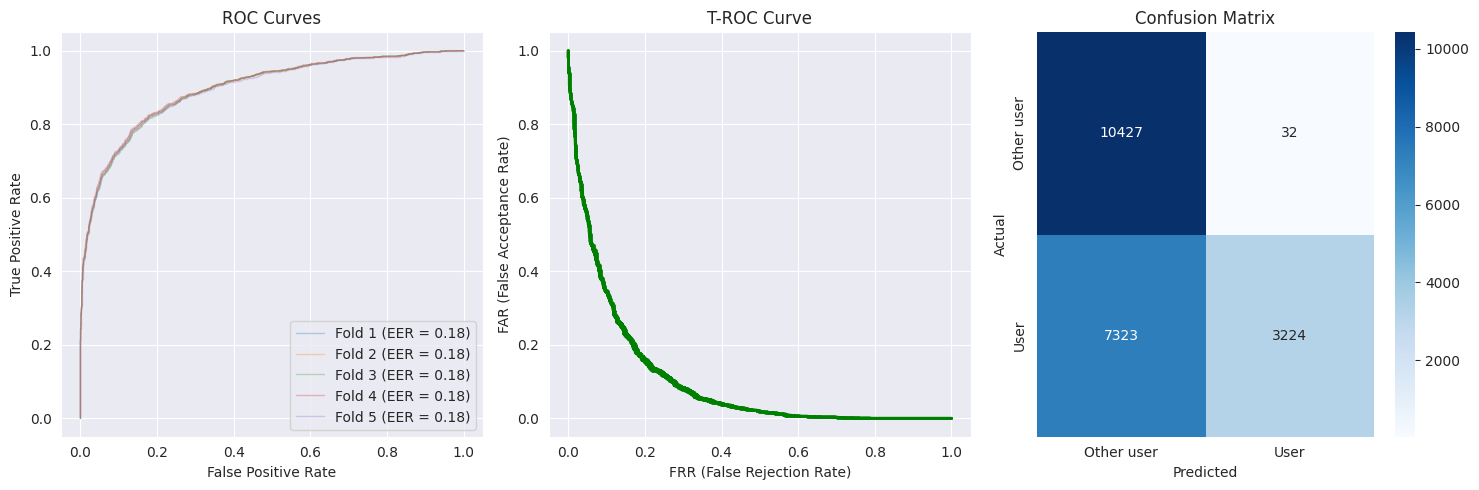

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [11]:
model = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",
                                                 task=tfdf.keras.Task.CLASSIFICATION,
                                                 # tuner=tuner,
                                                 l2_regularization=0.01)
final_df_list = []
all_far, all_frr, all_tpr, all_eer = [], [], [], []
cumulative_cm = np.zeros((2, 2))
for user in np.unique(y):
    res = (train_and_evaluate_for_user(model, None, X, y, X_test, y_test, user))
    final_df_list.append(res[0])
    all_far.append(np.mean(np.array(res[1])))
    all_frr.append(np.mean(np.array(res[1])))
    all_tpr.append(np.mean(np.array(res[1])))
    all_eer.append(np.mean(np.array(res[1])))
    cumulative_cm += res[5]

### Verification system evaluation - summary

In [ ]:
all_frr

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(mean_far, mean_tpr, lw=1, alpha=0.3)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curves')
ax[0].legend(loc='lower right')


ax[1].plot(mean_frr, mean_far, color='green', linewidth=2)
ax[1].set_title('T-ROC Curve')
ax[1].set_xlabel('FRR (False Rejection Rate)')
ax[1].set_ylabel('FAR (False Acceptance Rate)')

sns.heatmap(cumulative_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Other user', 'User'],
              yticklabels=['Other user', 'User'], ax=ax[2])
ax[2].set_title('Confusion Matrix')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
"""import lightgbm
def run_cv_tf(model, X, y, X_valid, y_valid, n_splits=5, name='',
           plot_path='results_identification/', title = None, is_multiclass=True):
    lgbm_model = lightgbm.LGBMClassifier()
    gbt_model = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",
                                                 task=tfdf.keras.Task.CLASSIFICATION,
                                                 # tuner=tuner,
                                                 l2_regularization=0.01)

    kf = KFold(n_splits=n_splits)
    results = []
    all_far = []
    all_frr = []
    all_tpr = []
    all_eer = []
    cumulative_cm = np.zeros((2, 2))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logger.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1000)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)
        X_valid, no_use_x, y_valid, no_use_y = train_test_split(X_valid, y_valid, test_size=0.1)

        # Train LightGBM
        lgbm_model.set_params(**{'objective': custom_asymmetric_train}, metrics=["precision"])
        lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=custom_asymmetric_valid)
        
        
        model.fit(train_dataset)
        model.compile(metrics=[AUC()])
        predictions = model.predict(X_valid, verbose=2)
        gbt_preds = np.hstack((1 - predictions, predictions))
        # Train GBT

        # Predict using LightGBM
        lgbm_preds = lgbm_model.predict_proba(X_valid)

        # Ensemble predictions by averaging
        ensemble_preds = (lgbm_preds + gbt_preds) / 2
        ensemble_final_preds = np.argmax(ensemble_preds, axis=1)

        y_score = ensemble_preds[:, 1]
        far, tpr, _ = roc_curve(y_valid, y_score)
        frr = 1 - tpr
        all_frr.append(frr)
        all_far.append(far)
        all_tpr.append(tpr)
        eer_index = np.nanargmin(np.absolute(far - frr))
        eer = (far[eer_index] + frr[eer_index]) / 2
        all_eer.append(eer)

        cm = confusion_matrix(y_valid, ensemble_final_preds)
        cumulative_cm += cm
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i, (far, tpr) in enumerate(zip(all_far, all_tpr)):
        ax[0].plot(far, tpr, lw=1, alpha=0.3, label=f'Fold {i + 1} (EER = {all_eer[i]:.2f})')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC Curves')
    ax[0].legend(loc='lower right')

    for i, (far, frr) in enumerate(zip(all_far, all_frr)):
        ax[1].plot(frr, far, color='green', linewidth=2)

    ax[1].set_title('T-ROC Curve')
    ax[1].set_xlabel('FRR (False Rejection Rate)')
    ax[1].set_ylabel('FAR (False Acceptance Rate)')

    sns.heatmap(cumulative_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Other user', 'User'],
                yticklabels=['Other user', 'User'], ax=ax[2])
    ax[2].set_title('Confusion Matrix')
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)
    """